In [1]:
!gcloud config set project etsy-bigquery-adhoc-prod


If you have a compatible Python interpreter installed, you can use it by setting
the CLOUDSDK_PYTHON environment variable to point to it.

Updated property [core/project].


In [2]:
%load_ext google.cloud.bigquery

In [120]:
import sys
import pickle
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm
from scipy.stats import pearsonr, ttest_1samp, ttest_ind, boxcox

# Taxonomy by GMS

In [4]:
%%bigquery
with listing_taxo_gms as (
  SELECT 
    g.listing_id, 
    total_gms, past_year_gms,
    full_path,
    SPLIT(full_path, '.')[OFFSET(0)] as top_taxonomy,
  FROM `etsy-data-warehouse-prod.listing_mart.listing_gms_active` g
  JOIN `etsy-data-warehouse-prod.materialized.listing_taxonomy` taxo
  ON g.listing_id = taxo.listing_id
)
select top_taxonomy, sum(past_year_gms) / 1000000 as total_past_year_gms_millions
from listing_taxo_gms
group by top_taxonomy
order by total_past_year_gms_millions desc

Downloading: 100%|████████████████████████████| 15/15 [00:02<00:00,  6.60rows/s]


,top_taxonomy,total_past_year_gms_millions
0,home_and_living,2566.302077000
1,jewelry,1172.396129160
2,clothing,926.281021080
3,craft_supplies_and_tools,745.821054390
4,art_and_collectibles,543.660009860
5,paper_and_party_supplies,519.185670130
6,weddings,502.681163060
7,accessories,427.321447240
8,toys_and_games,301.717870530
9,bags_and_purses,192.104032910


In [5]:
%%bigquery df 
with listing_taxo_gms as (
  SELECT 
    g.listing_id, 
    total_gms, past_year_gms,
    full_path,
    SPLIT(full_path, '.')[OFFSET(0)] as top_taxonomy,
    CASE
      WHEN array_length(SPLIT(full_path, '.')) > 1 THEN SPLIT(full_path, '.')[OFFSET(1)]
      else ""
    END AS second_taxonomy,
  FROM `etsy-data-warehouse-prod.listing_mart.listing_gms_active` g
  JOIN `etsy-data-warehouse-prod.materialized.listing_taxonomy` taxo
  ON g.listing_id = taxo.listing_id
),
listing_taxo_gms_cleaned as (
  select 
    listing_id, 
    total_gms, past_year_gms,
    case 
      when second_taxonomy != "" then CONCAT(top_taxonomy, '.', second_taxonomy)
      else top_taxonomy
    end as level2_taxonomy
  from listing_taxo_gms
)
select level2_taxonomy, sum(past_year_gms) / 1000000 as total_past_year_gms_millions
from listing_taxo_gms_cleaned
group by level2_taxonomy
order by total_past_year_gms_millions desc

Downloading: 100%|██████████████████████████| 181/181 [00:02<00:00, 86.03rows/s]


In [7]:
df.head(n=20)

,level2_taxonomy,total_past_year_gms_millions
0,home_and_living.home_decor,1013.785326200
1,clothing.gender_neutral_adult_clothing,465.623877230
2,home_and_living.kitchen_and_dining,387.658382380
3,jewelry.necklaces,364.505138170
4,paper_and_party_supplies.paper,308.390513390
5,jewelry.rings,304.937583070
6,weddings.gifts_and_mementos,253.439064220
7,clothing.womens_clothing,241.863066690
8,art_and_collectibles.prints,230.395509590
9,home_and_living.furniture,214.595747950


In [8]:
df.tail(n=20)

,level2_taxonomy,total_past_year_gms_millions
161,accessories.hand_fans,1.171161120
162,craft_supplies_and_tools.glue_and_adhesives,1.143414970
163,electronics_and_accessories.maker_supplies,1.141695950
164,bath_and_beauty.bath_accessories,0.894245780
165,craft_supplies_and_tools.brushes,0.699940020
166,pet_supplies.training,0.659369450
167,electronics_and_accessories.batteries_and_char...,0.651535310
168,craft_supplies_and_tools.imaging_and_lighting,0.610036460
169,electronics_and_accessories.tv_and_projection,0.589651330
170,accessories.umbrellas_and_rain_accessories,0.524890210


# Taxonomy consistency vs conversion rate

In [5]:
%%bigquery qdf
with query_data as (
    select distinct query, sum(impressions) as impressions, sum(clicks) as clicks, sum(purchases) as purchases
    from `etsy-data-warehouse-prod.search.visit_level_listing_impressions` 
    where _date = date("2023-07-18") 
    and page = "search"
    and query is not null
    group by query
)
select 
    qd.*
    , qd.clicks / (qd.impressions + 0.0001) as click_rate
    , qd.purchases / (qd.clicks + 0.0001) as post_click_cvr
from query_data qd

Downloading: 100%|██████████████| 3648778/3648778 [00:04<00:00, 775126.37rows/s]


In [6]:
qdf = qdf[np.logical_and(qdf.click_rate <= 1.0, qdf.post_click_cvr <= 1.0)]
print(qdf.shape)
print(len(qdf["query"].unique()))

(3647874, 6)
3647874


In [7]:
qdf.head()

,query,impressions,clicks,purchases,click_rate,post_click_cvr
0,alert,468,2,0,0.004274,0.0000
1,compost,564,5,0,0.008865,0.0000
2,tshirt svg woman,366,1,1,0.002732,0.9999
3,kenenergy,42,2,0,0.047619,0.0000
4,fart embroidery,42,5,0,0.119047,0.0000


In [8]:
%%bigquery fdf
with train_data as (
    select
        ctx.docInfo.queryInfo.query, 
        ctx.docInfo.queryInfo.queryTaxoDemandFeatures.*, 
    from `etsy-ml-systems-prod.attributed_instance.query_pipeline_web_organic_2023_07_18`, 
        unnest(contextualInfo) as ctx
    where userCountry = "US"
),
query_data as (
    select distinct query, sum(impressions) as impressions, sum(clicks) as clicks, sum(purchases) as purchases
    from `etsy-data-warehouse-prod.search.visit_level_listing_impressions` 
    where _date = date("2023-07-18") 
    and page = "search"
    and query is not null
    group by query
)
select * from train_data
where query in (
  select query from query_data
)
limit 5000000

Downloading: 100%|███████████████| 5000000/5000000 [01:48<00:00, 46220.45rows/s]


Find queries with high conversion rate 

In [21]:
np.quantile(qdf.click_rate, 0.8)

0.023255800432674167

In [68]:
qdf["high_click"] = (qdf.click_rate >= np.quantile(qdf.click_rate, 0.8)).apply(lambda x: "high_click" if x else "others")
qdf["high_cvr"] = (qdf.post_click_cvr >= 0.02).apply(lambda x: "high_cvr" if x else "others")

In [69]:
qdf.high_cvr.value_counts()

high_cvr
others      3539086
high_cvr     108788
Name: count, dtype: int64

In [70]:
qdf.high_click.value_counts()

high_click
others        2918079
high_click     729795
Name: count, dtype: int64

In [71]:
qdf.head()

,query,impressions,clicks,purchases,click_rate,post_click_cvr,high_click,high_cvr
0,alert,468,2,0,0.004274,0.0000,others,others
1,compost,564,5,0,0.008865,0.0000,others,others
2,tshirt svg woman,366,1,1,0.002732,0.9999,others,high_cvr
3,kenenergy,42,2,0,0.047619,0.0000,high_click,others
4,fart embroidery,42,5,0,0.119047,0.0000,high_click,others


In [72]:
fdf.head()

,query,impressionCount,clickCount,purchaseCount,impressionTopTaxonomyPaths,impressionTopTaxonomyCounts,impressionTopTaxonomyPrices,clickTopTaxonomyPaths,clickTopTaxonomyCounts,clickTopTaxonomyPrices,...,purchaseTopTaxonomyPrices,impressionLevel2TaxonomyPaths,impressionLevel2TaxonomyCounts,impressionLevel2TaxonomyPrices,clickLevel2TaxonomyPaths,clickLevel2TaxonomyCounts,clickLevel2TaxonomyPrices,purchaseLevel2TaxonomyPaths,purchaseLevel2TaxonomyCounts,purchaseLevel2TaxonomyPrices
0,magnet,299973.0,5883.0,165.0,"[home_and_living, art_and_collectibles, craft_...","[250303, 11071, 10623, 10356, 10219, 2627, 124...","[12.11, 44.34, 11.67, 12.56, 9.46, 8.54, 367.4...","[home_and_living, weddings, craft_supplies_and...","[5039, 246, 190, 176, 141, 38, 27, 26]","[10.65, 5.23, 6.69, 9.62, 8.47, 9.31, 96.39, 5...",...,"[10.38, 6.7, 6.0, 8.5]","[home_and_living.kitchen_and_dining, weddings....","[234596, 9635, 8554, 8235, 7284, 4726, 4716, 2...","[10.88, 10.92, 10.0, 8.6, 9.16, 9.09, 27.11, 6...","[home_and_living.kitchen_and_dining, weddings....","[4834, 237, 127, 125, 116, 110, 41, 26, 25, 23...","[10.77, 5.39, 7.19, 8.63, 8.31, 7.38, 8.95, 7....","[home_and_living.kitchen_and_dining, home_and_...","[137, 11, 4, 4, 4, 3, 2, 2, 2]","[10.9, 4.83, 6.0, 8.5, 9.46, 4.47, 5.69, 1.53,..."
1,national park print,21079.0,969.0,26.0,"[art_and_collectibles, home_and_living, clothi...","[14225, 5802, 360, 325, 183, 102, 82]","[29.49, 37.02, 29.39, 8.96, 14.78, 26.68, 13.35]","[art_and_collectibles, home_and_living, craft_...","[787, 169, 7, 3, 3]","[41.76, 31.87, 22.73, 38.67, 5.45]",...,"[28.54, 27.83]","[art_and_collectibles.prints, home_and_living....","[11932, 5551, 1010, 734, 351, 303, 283, 250, 1...","[27.38, 37.29, 37.79, 48.18, 29.41, 8.53, 19.2...","[art_and_collectibles.prints, home_and_living....","[616, 164, 100, 67, 5, 3, 3, 2, 2, 2, 2, 2]","[32.13, 31.88, 45.79, 72.76, 23.89, 28.33, 38....","[art_and_collectibles.prints, home_and_living....","[17, 6]","[28.87, 27.83]"
2,crown,610184.0,6291.0,137.0,"[weddings, accessories, paper_and_party_suppli...","[255057, 214139, 39682, 39153, 22696, 19192, 1...","[60.8, 63.96, 27.01, 122.0, 1064.19, 608.64, 2...","[accessories, weddings, craft_supplies_and_too...","[2596, 2464, 457, 307, 196, 162, 53, 39, 14, 3]","[65.02, 67.37, 4.9, 15.26, 1199.96, 890.1, 16....",...,"[37.76, 42.84, 3.74]","[weddings.accessories, accessories.hair_access...","[249112, 163065, 47238, 31881, 16726, 10113, 8...","[54.16, 50.76, 111.69, 20.02, 3.72, 3.17, 1679...","[weddings.accessories, accessories.hair_access...","[2399, 2132, 453, 300, 242, 93, 76, 74, 61, 60...","[51.63, 51.92, 127.92, 3.7, 18.5, 4.35, 1.61, ...","[weddings.accessories, accessories.hair_access...","[42, 38, 31, 15, 14, 11, 10, 9, 7, 2, 2, 2]","[42.45, 43.53, 2.9, 23.14, 9.14, 1.44, 1.0, 5...."
3,wedding guest book,1843982.0,28015.0,1299.0,"[weddings, paper_and_party_supplies, home_and_...","[1691837, 91759, 43550, 7699, 5288, 3849]","[52.23, 28.48, 78.11, 24.38, 15.75, 50.38]","[weddings, paper_and_party_supplies, home_and_...","[26347, 1094, 504, 37, 33]","[47.04, 27.43, 78.34, 36.6, 16.02]",...,"[44.65, 22.94, 76.22]","[weddings.gifts_and_mementos, weddings.decorat...","[1558498, 121385, 81968, 42201, 9431, 6348, 62...","[52.17, 50.95, 30.43, 77.26, 12.38, 126.0, 7.7...","[weddings.gifts_and_mementos, weddings.decorat...","[25231, 1032, 1019, 499, 75, 52, 35, 30, 27, 2...","[46.89, 47.01, 28.43, 77.72, 13.83, 145.39, 19...","[weddings.gifts_and_mementos, paper_and_party_...","[1198, 54, 25, 21]","[44.52, 22.94, 44.67, 76.22]"
4,mario birthday,74972.0,1015.0,42.0,"[paper_and_party_supplies, clothing, craft_sup...","[41357, 15770, 7460, 7233, 1987, 788, 377]","[11.65, 13.02, 7.22, 8.51, 16.38, 19.79, 3.23]","[paper_and_party_supplies, clothing, craft_sup...","[660, 131, 111, 70, 30, 13]","[14.26, 11.28, 9.09, 6.0, 24.18, 16.76]",...,"[10.53, 9.12]","[paper_and_party_supplies.paper, paper_and_par...","[22660, 18613, 10764, 5608, 4508, 3038, 2752, .

In [73]:
high_cvr_feature_data = []
other_feature_data = []
    
unique_queries = fdf["query"].unique()
print(len(unique_queries))

88558


In [74]:
qdf_query_set = set(qdf["query"])
fdf_query_set = set(fdf["query"])
len(qdf_query_set.intersection(fdf_query_set))

88549

In [80]:
qdf_high_set = set(qdf[qdf["high_cvr"] == "high_cvr"]["query"])
len(qdf_high_set.intersection(fdf_query_set))

12449

In [75]:
def l1norm(x):
    if len(x) > 0 and np.sum(x) > 0:
        return x / np.sum(x)
    else:
        return x

In [82]:
for i in tqdm(range(len(unique_queries))):
    curr_query = unique_queries[i]
    if curr_query in qdf_query_set:
        curr_qdf = qdf[qdf["query"] == curr_query]
        curr_fdf = fdf[fdf["query"] == curr_query]
        
        # query stats
        query_cvr_type = curr_qdf.high_cvr.values[0]
        query_cvr = curr_qdf.post_click_cvr.values[0]
        query_ctr = curr_qdf.click_rate.values[0]
        
        # top paths
        curr_impression_top_paths = curr_fdf.impressionTopTaxonomyPaths.values[0]
        curr_click_top_paths = curr_fdf.clickTopTaxonomyPaths.values[0]
        curr_purchase_top_paths = curr_fdf.purchaseTopTaxonomyPaths.values[0]
        
        # top counts
        curr_impression_top_counts = curr_fdf.impressionTopTaxonomyCounts.values[0]
        curr_click_top_counts = curr_fdf.clickTopTaxonomyCounts.values[0]
        curr_purchase_top_counts = curr_fdf.purchaseTopTaxonomyCounts.values[0]
        
        # level2 paths
        curr_impression_level2_paths = curr_fdf.impressionLevel2TaxonomyPaths.values[0]
        curr_click_level2_paths = curr_fdf.clickLevel2TaxonomyPaths.values[0]
        curr_purchase_level2_paths = curr_fdf.purchaseLevel2TaxonomyPaths.values[0]
        
        # level2 counts
        curr_impression_level2_counts = curr_fdf.impressionLevel2TaxonomyCounts.values[0]
        curr_click_level2_counts = curr_fdf.clickLevel2TaxonomyCounts.values[0]
        curr_purchase_level2_counts = curr_fdf.purchaseLevel2TaxonomyCounts.values[0]
        
        curr_res = {
            "query": curr_query,
            "cvr": query_cvr,
            "ctr": query_ctr,
            "i_top_path": curr_impression_top_paths,
            "i_top_counts": curr_impression_top_counts,
            "i_top_counts_norm": l1norm(curr_impression_top_counts),
            "c_top_path": curr_click_top_paths,
            "c_top_counts": curr_click_top_counts,
            "c_top_counts_norm": l1norm(curr_click_top_counts),
            "p_top_path": curr_purchase_top_paths,
            "p_top_counts": curr_purchase_top_counts,
            "p_top_counts_norm": l1norm(curr_purchase_top_counts),
            "i_level2_path": curr_impression_level2_paths,
            "i_level2_counts": curr_impression_level2_counts,
            "i_level2_counts_norm": l1norm(curr_impression_level2_counts),
            "c_level2_path": curr_click_level2_paths,
            "c_level2_counts": curr_click_level2_counts,
            "c_level2_counts_norm": l1norm(curr_click_level2_counts),
            "p_level2_path": curr_purchase_level2_paths,
            "p_level2_counts": curr_purchase_level2_counts,
            "p_level2_counts_norm": l1norm(curr_purchase_level2_counts),
        }
        
        if query_cvr_type == "high_cvr":
            high_cvr_feature_data.append(curr_res)
        else:
            other_feature_data.append(curr_res)


100%|██████████████████████████████████| 88558/88558 [18:39:34<00:00,  1.32it/s]


In [83]:
print(len(high_cvr_feature_data))
print(len(other_feature_data))

12815
76424


In [88]:
with open("high_cvr_data.pkl", "wb") as f1:
    pickle.dump(high_cvr_feature_data, f1)
    
with open("other_cvr_data.pkl", "wb") as f2:
    pickle.dump(other_feature_data, f2)

In [89]:
# high purchase taxonomy entropy but low impression taxonomy entropy
# low purchase taxonomy entropy but high impression taxonomy entropy
# entropy: number of high-demand taxonomies

high_cvr_purchase_entropy = [len(x["p_level2_path"]) for x in high_cvr_feature_data]
high_cvr_impression_entropy = [len(x["i_level2_path"]) for x in high_cvr_feature_data]

other_purchase_entropy = [len(x["p_level2_path"]) for x in other_feature_data]
other_impression_entropy = [len(x["i_level2_path"]) for x in other_feature_data]

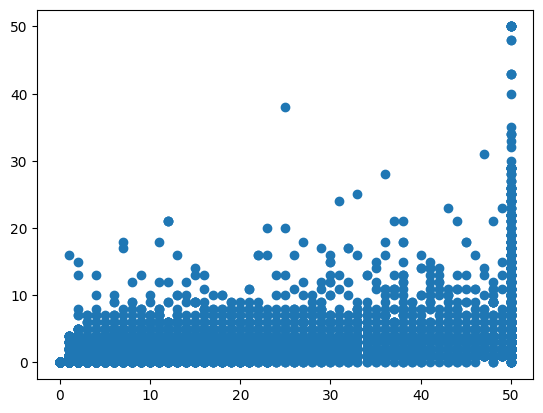

In [124]:
plt.scatter(high_cvr_impression_entropy, high_cvr_purchase_entropy)

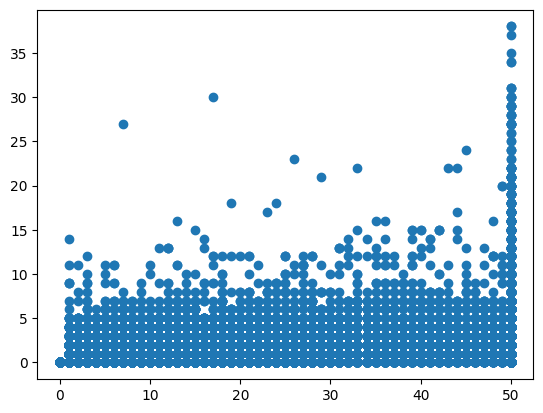

In [125]:
plt.scatter(other_impression_entropy, other_purchase_entropy)

In [127]:
# queries with high impression & low purchase
np.quantile(high_cvr_impression_entropy, 0.8)

38.0

In [129]:
np.quantile(high_cvr_purchase_entropy, 0.8)

3.0

In [130]:
i = 0
ppaths = high_cvr_feature_data[i]["p_level2_path"]
pcounts = high_cvr_feature_data[i]["p_level2_counts_norm"]
ipaths = high_cvr_feature_data[i]["i_level2_path"]
icounts = high_cvr_feature_data[i]["i_level2_counts_norm"]

union_paths = set(ppaths).intersection(set(ipaths))
j = 0

if union_paths[j] in ppaths:
    curr_pcounts = pcounts[ppaths.index(union_paths[j])] if union_paths[j] in ppaths else 0.0
    curr_icounts = icounts[ipaths.index(union_paths[j])] if union_paths[j] in ipaths else 0.0
    distrib_dist = np.abs(curr_pcounts, curr_icounts)

In [138]:
pcounts[ppaths == union_paths[0]][0]

0.0650887573964497

In [134]:
union_paths = set(ppaths).intersection(set(ipaths))

array([7.84156165e-01, 3.22057693e-02, 2.85924391e-02, 2.75261557e-02,
       2.43473610e-02, 1.57970385e-02, 1.57636127e-02, 6.96259652e-03,
       5.85285958e-03, 5.33810208e-03, 4.72306715e-03, 3.77043153e-03,
       3.66346893e-03, 3.52308052e-03, 2.95149915e-03, 2.91138817e-03,
       2.82782365e-03, 2.42002875e-03, 2.23284420e-03, 2.18270549e-03,
       2.01557643e-03, 1.74148477e-03, 1.64789250e-03, 1.51418926e-03,
       1.34706020e-03, 1.31697697e-03, 1.17993114e-03, 1.12644984e-03,
       9.76033693e-04, 8.72413678e-04, 7.88849149e-04, 7.58765919e-04,
       6.95256877e-04, 6.68516228e-04, 6.21720092e-04, 5.98322024e-04,
       5.58211051e-04, 4.37878129e-04, 4.37878129e-04, 4.17822643e-04,
       3.84396831e-04, 3.07517465e-04, 2.64063910e-04, 2.64063910e-04,
       2.54036167e-04, 2.40665842e-04, 2.20610355e-04, 2.17267774e-04,
       2.03897450e-04, 1.73814219e-04])

In [142]:
high_cvr_distrib_dist = []

for i in range(len(high_cvr_feature_data)):
    ppaths = high_cvr_feature_data[i]["p_level2_path"]
    pcounts = high_cvr_feature_data[i]["p_level2_counts_norm"]
    ipaths = high_cvr_feature_data[i]["i_level2_path"]
    icounts = high_cvr_feature_data[i]["i_level2_counts_norm"]

    union_paths = list(set(ppaths).union(set(ipaths)))
    if len(union_paths) > 0:
        distrib_dist = 0.
        for j in range(len(union_paths)):
            curr_pcounts = pcounts[ppaths == union_paths[j]][0] if union_paths[j] in ppaths else 0.0
            curr_icounts = icounts[ipaths == union_paths[j]][0] if union_paths[j] in ipaths else 0.0
            distrib_dist += np.abs(curr_pcounts - curr_icounts)

        high_cvr_distrib_dist.append(distrib_dist / len(union_paths))

In [145]:
other_distrib_dist = []

for i in range(len(other_feature_data)):
    ppaths = other_feature_data[i]["p_level2_path"]
    pcounts = other_feature_data[i]["p_level2_counts_norm"]
    ipaths = other_feature_data[i]["i_level2_path"]
    icounts = other_feature_data[i]["i_level2_counts_norm"]

    union_paths = list(set(ppaths).union(set(ipaths)))
    if len(union_paths) > 0:
        distrib_dist = 0.
        for j in range(len(union_paths)):
            curr_pcounts = pcounts[ppaths == union_paths[j]][0] if union_paths[j] in ppaths else 0.0
            curr_icounts = icounts[ipaths == union_paths[j]][0] if union_paths[j] in ipaths else 0.0
            distrib_dist += np.abs(curr_pcounts - curr_icounts)

        other_distrib_dist.append(distrib_dist / len(union_paths))